# COMP9418 - Assignment 1 - Bayesian Network, Naïve Bayes and TAN Bayes Classifiers

## UNSW Sydney, September 2023

- Weng Xinn Chow (z5346077)

## Instructions

**Submission deadline:** Sunday, 15th October 2023, at 18:00:00 AEDT.

**Late Submission Policy:** The penalty is set at $5\%$ per late day for a maximum of 5 days. This is the UNSW standard late penalty. For example, if an assignment receives an on-time mark of $70/100$ and is submitted three days late, it will receive a mark reduction of $70/100*15\%$. After five days, the assignment will receive a mark reduction of $100\%$.

**Form of Submission:** This is an **individual** or group of **two students** assignment. Write the name(s) and zID(s) in this Jupyter notebook. **If submitted in a group, only one member should submit the assignment. Also, create a group on WebCMS by clicking on Groups and Create and include both group members**.

You can reuse any piece of source code developed in the tutorials.

You can submit your solution via [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/22T3).

Alternatively, you can submit your solution using give. On a CSE Linux machine, type the following on the command line:

``$ give cs9418 ass1 solution.zip``

## Technical prerequisites

These are the libraries you are allowed to use. No other libraries will be accepted. Make sure you are using Python 3.

In [384]:
# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from graphviz import Digraph
from tabulate import tabulate
import copy
from sklearn.model_selection import KFold

We can also use the python files we developed in tutorials or any other code from the tutorials.

In [385]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet import BayesNet

## Task 0 - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [386]:
G = Graph({
    "LymphNodes": [],
    'Metastasis': ["LymphNodes"],
    "BC": ["Metastasis","Mass","AD","NippleDischarge","SkinRetract","MC"],
    "Age": ["BC"],
    "Location": ["BC"],
    "MC": [],
    "SkinRetract": [],
    "NippleDischarge": [],
    "AD": ["FibrTissueDev"],
    "FibrTissueDev": ["NippleDischarge","SkinRetract","Spiculation"],
    "Spiculation": ["Margin"],
    "Margin": [],
    "Mass": ["Margin","Shape","Size"],
    "Shape": [],
    "Size": [],
    "BreastDensity": ["Mass"],
})

### Load data

In [387]:
# load data
with open('bc.csv') as file:
    data = pd.read_csv(file)

# remove 2 variables from data (because we are pretending we don't know this information)
if 'Metastasis' in data:
    del data['Metastasis']
if 'LymphNodes' in data:
    del data['LymphNodes']

# remove same 2 nodes from graph
G.remove_node('Metastasis')
G.remove_node('LymphNodes')

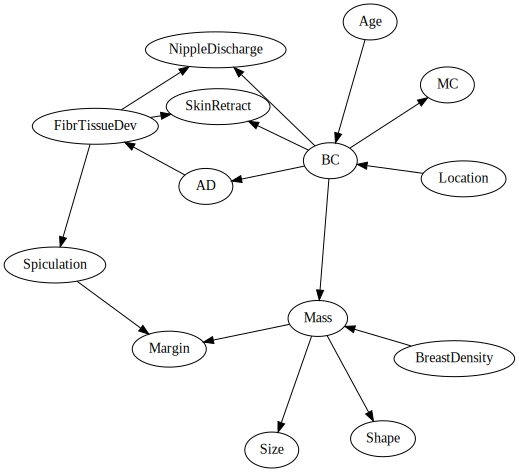

In [388]:
# Inspect graph visually
G.show()

### Helper Functions

In [389]:
def remove_leaf_nodes(G, kept_nodes):
    removed_nodes = []
    for node in G.adj_list.keys():
        if node not in kept_nodes:
            if len(G.adj_list[node]) < 1:
                removed_nodes.append(node)
    
    for node in removed_nodes:
        G.remove_node(node)
    if len(removed_nodes) > 0:
        return True
    return False

def get_children(G, node):
    return G.children(node)

def get_parents(G, node):
    GT = G.transpose()
    return GT.children(node)

def get_spouses(G, node):
    spouses = []
    children = get_children(G, node)
    for child in children: 
        child_parents = get_parents(G, child)
        spouses += child_parents
        
    return spouses

def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def laplace_estimate_factor(dataframe, var_name, parent_names, outcomeSpace, alpha):
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    all_parent_combinations = product(*parent_outcomes)
    
    f = Factor(list(parent_names)+[var_name], outcomeSpace)
    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(dataframe, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(dataframe[var_name]) == var_outcome)
            numerator = ((var_index & parent_index).sum() + alpha)
            denominator = (parent_index.sum() + (alpha * len(var_outcomes)))
            # P(var|parents) = (count(var,parents) + alpha) / count(parents) + (alpha*K)
            # K: possible values of var
            f[tuple(list(parent_combination)+[var_outcome])] = numerator / denominator
            
    return f

def joint_efficient(factors):
        factor_list = list(factors.values())

        accumulator = factor_list[0]
        for factor in factor_list[1:]:
            accumulator = accumulator.join(factor)
        return accumulator
    
def query_efficient(factors, q_vars, **q_evi):
    assert isinstance(q_vars,list) or isinstance(q_vars,tuple), "q_vars should be a list"
    
    f = joint_efficient(factors)

    # Second, we eliminate hidden variables NOT in the query
    for var in outcomeSpace:
        if var not in q_vars and var not in list(q_evi):
            f = f.marginalize(var)
    return f.normalize()

def mutual_information(dataframe, var_names, parent_name, outcomeSpace, alpha=1):
    num_combinations = 1
    var_outcomes = []
    for var in var_names:
        var_outcomes.append(outcomeSpace[var])
        num_combinations *= len(outcomeSpace[var])
    parent_outcomes = outcomeSpace[parent_name]
    num_total_combinations = num_combinations * len(parent_outcomes)
    
    mi = 0
    
    for parent_outcome in parent_outcomes:
        parent_index = (np.asarray(dataframe[parent_name]) == parent_outcome)
        all_var_combinations = product(*var_outcomes)
        for i, var_combination in enumerate(all_var_combinations):
            var_vars = dict(zip(var_names, var_combination))
            var_index = allEqualThisIndex(dataframe, **var_vars)
            # P(var1,var2|parent)
            numerator = ((var_index & parent_index).sum() + alpha)
            denominator = (parent_index.sum() + (alpha * num_combinations))
            mutual_numerator = numerator / denominator
            
            # P(var1,var2,parent)
            denominator2 = (len(dataframe)) + (alpha * num_total_combinations)
            mutual_join_prob = numerator / denominator2
            
            mutual_denominator = 1
            # P(var1|parent) * P(var2|parent)
            for var_name, var_var in var_vars.items():
                var= {}
                var[var_name] = var_var
                var_index = allEqualThisIndex(dataframe, **var)
                numerator = ((var_index & parent_index).sum() + alpha)
                denominator = (parent_index.sum() + (alpha * len(outcomeSpace[var_name]) * len(parent_outcomes)))
                mutual_denominator *= numerator / denominator
                
            # Mutual information
            # P(var1,var2,parent) * log2 (P(var1,var2|parent) / ((P(var1|parent)) * P(var2|parent)))
            mi += mutual_join_prob * math.log2(mutual_numerator / mutual_denominator)
#             print(mutual_numerator)
#             print(mutual_denominator)
#             print(mutual_join_prob)
#             print(mutual_information)
#             print('\n')
    return mi

## [10 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: ``True`` if **X** is d-separated from **Y** given **Z** in the graph $G$ and ``False`` otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers and can be assumed to be nodes of the graph $G$. 
* $G$ is a directed graph object as defined in tutorial 1.

In [390]:
# Develop your code for d_separation(G, X, Z, Y) in this cell

def d_separation(G, X, Z, Y):
    '''
    Arguments:
        G:   is an object of type Graph (the class you developed in tutorial 1).
        X,Z and Y:  are python set objects.
    Returns:
        True if X is d-separared of Y given Z or False otherwise.
    '''
    G = G.copy()
    
    # Remove leaf nodes if they don't belong to the set of X U Y U Z
    kept_nodes = X | Y | Z
    remove = True
    while remove:
        remove = remove_leaf_nodes(G, kept_nodes)
    
    # Remove outgoing edges from nodes in Z
    for z in Z:
        G.remove_outgoing_from(z)
    
    # Check if X and Y are disconnected 
    # Convert to undirected graph because the check ignores directions
    G = G.convert_to_undirected()
    # nodeX and nodeY is disconnected if nodeY is not visited (white) in dfs starts from nodeX 
    for nodeX in X:
        visited_colours = G.dfs(nodeX)
        for nodeY in Y: 
            if visited_colours[nodeY] == 'white':
                return True
    return False

In [391]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation', 'SkinRetract']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [5 Marks] Task 2 - Markov blanket

The Markov blanket for a variable $X$ is a set of variables that, when observed, will render every other variable irrelevant to $X$. If the distribution is induced by DAG $G$, then a Markov blanket for variable $X$ can be constructed using $X$'s parents, children, and spouses in $G$. A variable $Y$ is a spouse of $X$ if the two variables have a common child in $G$.

In this exercise, we will implement a function `Markov(G, X)` that returns a python set with the Markov blanket of $X$ in $G$ as described above.

In [392]:
# Develop your code for Markov_blanket(G, X) in this cell

def Markov_blanket(G, X):
    '''
    Arguments:
        G:   is an object of type Graph (the class you developed in tutorial 1)
        X:   is a node (variable) in G.
    Returns: 
        A python set with the Markov blanket of X in G
    '''
    G = G.copy()
    Mb = set()
    
    # Markov blanket: parents, children and spouses
    Mb.update(get_children(G, X))
    Mb.update(get_parents(G, X))
    Mb.update(get_spouses(G, X))
    Mb = Mb.difference({X})
    return Mb

In [393]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

test(Markov_blanket(G, 'Mass') == set(['Margin', 'Size', 'Shape', 'BreastDensity', 'BC', 'Spiculation']))
test(Markov_blanket(G, 'Age') == set(['Location', 'BC']))

Passed test case
Passed test case


## Putting Tasks 1 and 2 together

This task is optional and will not be marked, but you can use it to test your code further. According to the Markov blanket definition: A Markov blanket for a variable $X \in \textbf{X}$ is the set of variables $\textbf{B} \subseteq \textbf{X}$ such that $X \notin \textbf{B}$ and $X \perp \textbf{X} \setminus (\textbf{B} \cup \{ X \}) | \textbf{B}$

In [394]:
# Develop your code to test your d-separation and Markov blanket implementations using the definition above.

set_X = {...}                                        # Set of all nodes in the graph
for X in set_X:
    mb = ...                                         # Markov_blanket of X
    ...                                              # Independence test according to the definition above

## [5 Marks] Task 3 - Learning the outcome space from data

Now, we will implement a series of functions to learn Bayesian network parameters from data. We will start by learning the outcome space of the variables in a Bayesian network. Remind from the tutorials that the outcome space is a python dictionary that maps the variable names to a tuple with the possible values this variable can have.

Implement a function ``learn_outcome_space(dataframe)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``dataframe`` and returns a dictionary ``outcomeSpace`` with these values.

In [395]:
# Develop your code for learn_outcome_space(dataframe) in this cell

def learn_outcome_space(dataframe):
    '''
    Arguments:
        dataframe:    A pandas dataframe
    Returns: 
        outcomeSpace: A dictionary. e.g. {'A':('True', 'False'), 'B':('up','down','left'), 'C':(1,2,3,4)}
    '''
    # Convert each column into dictionary, get the unique values 
    outcomeSpace = dataframe.to_dict('series')
    outcomeSpace = {node: tuple(set(values)) for node, values in outcomeSpace.items()}
    return outcomeSpace

In [396]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


In [397]:
data.head()

,BreastDensity,Location,Age,BC,Mass,AD,MC,Size,Shape,FibrTissueDev,SkinRetract,NippleDischarge,Spiculation,Margin
0,high,LolwOutQuad,35-49,No,No,No,No,<1cm,Other,No,No,No,No,Well-defined
1,medium,UpOutQuad,50-74,Invasive,Benign,No,Yes,<1cm,Oval,No,No,Yes,No,Well-defined
2,low,UpInQuad,50-74,Invasive,Benign,No,No,1-3cm,Other,Yes,Yes,No,Yes,Well-defined
3,medium,LowInQuad,>75,Invasive,Malign,No,Yes,<1cm,Round,No,No,No,No,Ill-defined
4,high,LowInQuad,<35,No,Benign,No,No,>3cm,Oval,No,No,No,Yes,Ill-defined


## [5 Marks] Task 4 - Estimate Bayesian network parameters from data

Implement a method ``model.learn_parameters(dataframe, alpha=1)`` that learns the parameters of the Bayesian Network `model`. This function should do the same as the ``learn_parameters`` function from tutorials, but it should also implement laplacian smoothing with parameter $\alpha$.

In [398]:
## Develop your code for model.learn_parameters(self, dataframe, alpha) in this cell

class BayesNet(BayesNet):
    def learn_parameters(self, dataframe, alpha=1):
        '''
        Arguments:
            data:    A pandas dataframe
            alpha:   Laplacian smoothing parameter
        '''        
        graphT = self.graph.transpose()
        for node, parents in graphT.adj_list.items():
            graphT = self.graph.transpose()
            factor = laplace_estimate_factor(dataframe, node, parents, self.outcomeSpace, alpha)
            self.factors[node] = factor

In [399]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)
model = BayesNet(G, outcomeSpace=outcomeSpace)

model.learn_parameters(data, alpha=1)

test(model.factors['Age']['35-49'] == 0.248000399920016)

Passed test case


## [5 Marks] Task 5 - Bayesian network classification

Design a new method ``model.predict(class_var, evidence)`` that implements the classification with complete data. This function should return the MPE value for the attribute `class_var` given the evidence. As we are working with complete data, `evidence` is an instantiation for all variables in the Bayesian network `model` but `class_var`.

**Implement the efficient classification procedure discussed in the lectures. Assure that you only join the necessary factors.**

In [400]:
## Develop your code for model.predict(class_var, evidence) in this cell

class BayesNet(BayesNet):
    def predict(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            The MPE value (class label) of class_var given evidence
        ''' 
        max_prob = 0
        mpe = None
        
        # Observe the evidence for each factor
        factors = {}
        for node, factor in self.factors.items():
            factors[node] = factor.evidence(**evidence)

        # Select only the relevant factors (factors that are dependent on class var)
        factors = {node: factor for node, factor in factors.items() 
                   if node in G.adj_list['BC'] or node == class_var }
        
        # Do the efficient query 
        query_factor = query_efficient(factors, [class_var], **evidence)
        
        # Find the max probability and its associated args (MPE)
        values = [evidence[node] for node in query_factor.domain if node in evidence]
        var_index = query_factor.domain.index(class_var)
        values.insert(var_index, None)
        for i, var_value in enumerate(outcomeSpace[class_var]):
            values[var_index] = var_value
            prob = query_factor[tuple(values)]
            if prob > max_prob:
                max_prob = prob
                mpe = var_value
        return mpe

In [401]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)
model = BayesNet(G, outcomeSpace=outcomeSpace)
model.learn_parameters(data, alpha=1)

evidence = {'Age': '35-49', 
    'Location': 'LolwOutQuad', 
    'MC': 'No', 
    'SkinRetract': 'No', 
    'NippleDischarge': 'No',
    'AD': 'No',
    'FibrTissueDev': 'No', 
    'Spiculation': 'No',
    'Margin': 'Well-defined', 
    'Mass': 'No',
    'Shape': 'Other', 
    'Size': '<1cm',
    'BreastDensity': 'high'}

test(model.predict('BC', evidence) == 'No')

Passed test case


## [5 Marks] Task 6 - Bayesian network accuracy estimation

Design a new function ``assess_bayes_net(model, dataframe, class_var)`` that uses the test cases in ``dataframe`` to assess the Bayesian network `model` performance at classifying the variable `class_var`. This function will return the accuracy of the Bayesian network according to the examples in ``dataframe``.

Remind that accuracy is the ratio of the number of correct predictions to the total number of cases.

In [402]:
## Develop your code for assess_bayes_net(model, dataframe, class_var) in this cell

model = BayesNet(...)
def assess_bayes_net(model, dataframe, class_var='BC'):
    '''
    Arguments:
        model:     Bayesian Network object
        dataframe: a Pandas dataframe object
        class_var: Variable identifier to be classified
    Returns:
        The accuracy of the Bayesian network model in classifying the cases in dataframe
    '''     
    evidences = dataframe.drop(class_var, axis=1).to_dict('records')
    y_trues = dataframe[class_var].tolist()
    y_preds = [] 
    num_correct_preds = 0
    num_cases = len(evidences)
    for i in range(len(evidences)):
        y_pred = model.predict(class_var, evidences[i])
        y_preds.append(y_pred)
        if y_pred == y_trues[i]:
            num_correct_preds += 1

    acc = num_correct_preds / num_cases
    
    return acc

In [403]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

model = BayesNet(G, outcomeSpace)
model.learn_parameters(data, alpha=1)

acc = assess_bayes_net(model, data, 'BC')
test(abs(acc-0.8423) < 0.001)

Passed test case


In [404]:
print(acc)

0.8423


## [5 Marks] Task 7 - Bayesian network assessment with cross-validation

Implement a function called `cross_validation_bayes_net(G, dataframe, class_var, k)`, compute and report the average accuracy of the Bayesian network specified by the graph `G` over a $k=10$ cross-validation runs as well as the standard deviation. A scaffold for this function is provided below.

In [405]:
## Develop your code for cross_validation_bayes_net(G, dataframe, class_var, k) in this cell

def cross_validation_bayes_net(G, dataframe, class_var='BC', k=10):
    '''
    Arguments:
        model:      Bayesian Network object
        dataframe:  a Pandas dataframe object
        class_var:  Variable identifier to be classified
        k:          number of cross-validation folds
    Returns:
        The mean accuracy and standand deviation of model across the k folds
    '''      
    accuracy_list = []
    
    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    for train, test in kf.split(dataframe):
      
        # train a model with learn_parameters
        train_set = dataframe.iloc[train]
        outcomeSpace = learn_outcome_space(dataframe)
        model = BayesNet(G, outcomeSpace=outcomeSpace)
        model.learn_parameters(train_set, alpha=1)
        
        # test the model with assess_bayes_net
        test_set = dataframe.iloc[test]
        acc = assess_bayes_net(model, test_set, class_var)
        
        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)

In [407]:
############
## TEST CODE

acc, stddev = cross_validation_bayes_net(G, data, 'BC', 10)
test(abs(acc - 0.85) < 0.05)

Passed test case


In [408]:
acc_bn = acc
acc_stddev = stddev
print(acc_bn)
print(acc_stddev)

0.8412000000000001
0.007991245209602845


## [5 Marks] Task 8 - Naïve Bayes classifier structure

Let's work now with the Naïve Bayes classifier. This classifier is a Bayesian network with a pre-defined structure (graph). Let's start creating a new function, ``learn_naive_bayes_structure(dataframe, class_var)``, that learns the Naïve Bayes graph structure from a pandas `dataframe` using `class_var` as the class variable.

In [409]:
## Develop your code for learn_naive_bayes_structure(dataframe, class_var) in this cell

def learn_naive_bayes_structure(dataframe, class_var):
    '''
    Arguments:
        dataframe:   A pandas dataframe
        class_var:   Variable identifier to be classified
    Returns:
        A Graph object with the structure of the Naïve Bayes classifier for the attributes in dataframe
    '''
    graph = Graph()
    for node in dataframe.columns:
        # Class var is the parents of all attributes 
        if node == class_var:
            graph.adj_list[node] = dataframe.columns.drop(class_var).tolist()
        # Attributes are independent given the class_var
        else:
            graph.adj_list[node] = []
    return graph

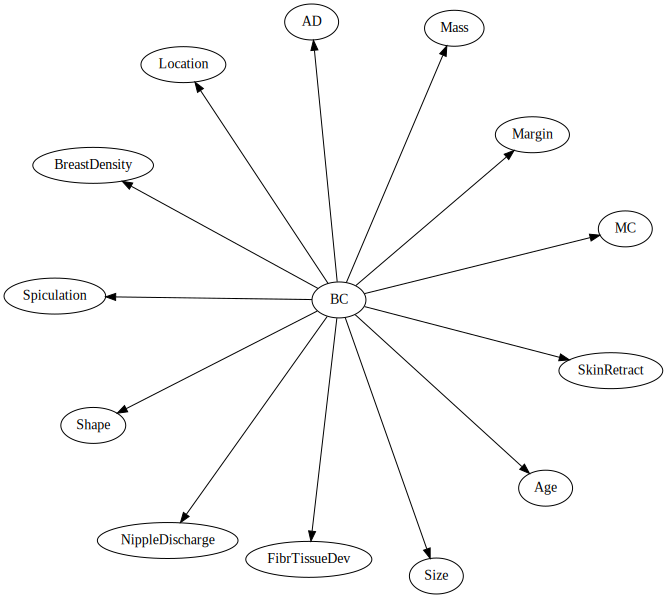

In [410]:
############
## TEST CODE

naiveG = learn_naive_bayes_structure(data, 'BC')
naiveG.show()

## [5 Marks] Task 9 - Naïve Bayes classification

As the Naïve Bayes classifier is a Bayesian network, we can use the existing `BayesNet` class to create a new class `NaiveBayes`.

Let's create a new method ``model.predict_log(class_var, evidence)`` that implements the classification with complete data. This function should return the MPE value for the attribute `class_var` given the `evidence`. As we work with complete data, `evidence` is an instantiation for all variables but `class_var`. **Use the log probability trick discussed in the lectures to classify each example**.

In [411]:
## Develop your code for model.predict_log(class_var, evidence) in this cell

class NaiveBayes(BayesNet):
    def predict_log(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            The MPE value (class label) of class_var given evidence
        '''        
        max_prob = -9999999
        mpe = None
        
        factors = {}
        
        for node, factor in self.factors.items():
            factors[node] = factor.evidence(**evidence)
            
        query_factor = query_efficient(factors, [class_var], **evidence)

        values = [evidence[node] for node in query_factor.domain if node in evidence]
        var_index = query_factor.domain.index(class_var)
        values.insert(var_index, None)
        for i, var_value in enumerate(outcomeSpace[class_var]):
            values[var_index] = var_value
            prob = query_factor[tuple(values)]
            log_prob = math.log(prob)
            if log_prob > max_prob:
                max_prob = log_prob
                mpe = var_value
        return mpe

In [412]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)
naiveG = learn_naive_bayes_structure(data, 'BC')
naive_model = NaiveBayes(naiveG, outcomeSpace=outcomeSpace)
naive_model.learn_parameters(data, alpha=1)
evidence = {'Age': '35-49', 
    'Location': 'LolwOutQuad', 
    'MC': 'No', 
    'SkinRetract': 'No', 
    'NippleDischarge': 'No',
    'AD': 'No',
    'FibrTissueDev': 'No', 
    'Spiculation': 'No',
    'Margin': 'Well-defined', 
    'Mass': 'No',
    'Shape': 'Other', 
    'Size': '<1cm',
    'BreastDensity': 'high'}

test(naive_model.predict_log('BC', evidence) == 'No')

Passed test case


## [5 Marks] Task 10 - Naïve Bayes accuracy estimation

Design a new function ``assess_naive_bayes(model, dataframe, class_var)`` that uses the test cases in ``dataframe`` to assess the performance of the Naïve Bayes classifier for the class variable `class_var`. This function will return the accuracy of the classifier according to the examples in the ``dataframe``.

In [413]:
## Develop your code for assess_naive_bayes(model, dataframe, class_var) in this cell

model = NaiveBayes(...)
def assess_naive_bayes(model, dataframe, class_var='BC'):
    '''
    Arguments:
        model:      Naive Bayes object
        dataframe:  a Pandas dataframe object
        class_var:  Variable identifier to be classified
    Returns:
        The accuracy of the Naive Bayes model in classifying the cases in dataframe
    '''      
    evidences = dataframe.drop(class_var, axis=1).to_dict('records')
    y_trues = dataframe[class_var].tolist()
    y_preds = [] 
    num_correct_preds = 0
    num_cases = len(evidences)
    for i in range(len(evidences)):
        y_pred = model.predict_log(class_var, evidences[i])
        y_preds.append(y_pred)
        if y_pred == y_trues[i]:
            num_correct_preds += 1

    acc = num_correct_preds / num_cases
    
    return acc

In [414]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

naive_model = NaiveBayes(naiveG, outcomeSpace)
naive_model.learn_parameters(data, alpha=1)

acc = assess_naive_bayes(naive_model, data, 'BC')
test(abs(acc-0.7926) < 0.001)

Passed test case


In [418]:
print(acc)

0.7919000000000002


## [5 Marks] Task 11 - Naïve Bayes assessment with cross-validation

Implement a function called `cross_validation_naive_bayes(dataframe, class_var, k)`, compute and report the average accuracy over the $k=10$-fold cross-validation runs as well as the standard deviation. A scaffold for this function is provided below.

In [419]:
## Develop your code for cross_validation_naive_bayes(dataframe, class_var, k) in this cell

def cross_validation_naive_bayes(dataframe, class_var='BC', k=10):
    accuracy_list = []
    
    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    for train, test in kf.split(dataframe):
      
        # train a model with learn_parameters
        train_set = dataframe.iloc[train]
        outcomeSpace = learn_outcome_space(dataframe)
        naiveG = learn_naive_bayes_structure(data, 'BC')
        naive_model = NaiveBayes(naiveG, outcomeSpace)
        naive_model.learn_parameters(train_set, alpha=1)
        
        # test the model with assess_naive_bayes
        test_set = dataframe.iloc[test]
        acc = assess_naive_bayes(naive_model, test_set, 'BC')
        
        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)  

In [420]:
############
## TEST CODE

acc, stddev = cross_validation_naive_bayes(data, 'BC')
test(abs(acc - 0.80) < 0.05)

Passed test case


In [421]:
acc_nb = acc
stddev_nb = stddev
print(acc_nb)
print(stddev_nb)

0.7919000000000002
0.006456779382943188


## [15 Marks] Task 12 - Tree-augmented naïve Bayes structure

Let's work now with the Tree-augmented Naïve Bayes classifier. We will start creating a new function, ``learn_tan_structure(dataframe, class_var)``, that learns the Tree-augmented Bayes graph structure from a pandas dataframe.

In [422]:
## Develop your code for learn_tan_structure(dataframe, class_var) in this cell

def learn_tan_structure(dataframe, class_var):
    '''
    Arguments:
        dataframe - A pandas dataframe
        class_var - Variable identifier to be classified
    Returns:
        A Graph object with the structure of the Naïve Bayes classifier for the attributes in dataframe and class_var
    '''
    graph = Graph()
    outcomeSpace = learn_outcome_space(dataframe)
    attributes = [node for node in dataframe.columns if node != class_var]
    visited_nodes = []
    for node1 in attributes:
        visited_nodes.append(node1)
        for node2 in attributes:
            if node1 != node2 and node2 not in visited_nodes:
                var_names = [node1, node2]
                mi = mutual_information(dataframe, var_names, class_var, outcomeSpace)
                graph.add_edge(node1, node2, weight=mi, directed=False)
    graph = graph.prim('MC')
    graph.adj_list[class_var] = attributes
    
    return graph

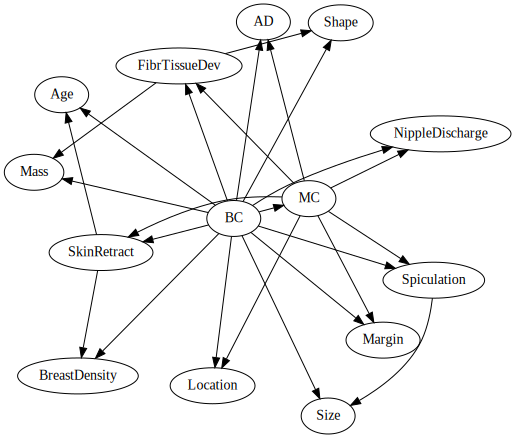

In [423]:
G1 = learn_tan_structure(data, 'BC')
G1.show()

In [424]:
############
## TEST CODE

tan_graph = learn_tan_structure(data, class_var='BC')
test(len(tan_graph.children('BC')) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph.children('Spiculation') or 'Spiculation' in tan_graph.children('FibrTissueDev'))

Passed test case
Failed test case !!!


## [5 Marks] Task 13 - Tree-augmented naïve Bayes assessment with cross-validation

Implement a function called `cross_validation_tan(dataframe, class_var, k)`, compute and report the average accuracy over the $k=10$-fold cross-validation runs and the standard deviation. A scaffold for this function is provided below.

In [425]:
## Develop your code for cross_validation_tan(dataframe, class_var, k) in this cell

def cross_validation_tan(dataframe, class_var='BC', k=10):
    accuracy_list = []
    
    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    for train, test in kf.split(dataframe):
        
        # train a model with learn_parameters
        train_set = dataframe.iloc[train]
        outcomeSpace = learn_outcome_space(dataframe)
        tanG = learn_tan_structure(data, class_var)
        model = BayesNet(tanG, outcomeSpace=outcomeSpace)
        model.learn_parameters(train_set, alpha=1)
        
        # test the model with assess_bayes_net
        test_set = dataframe.iloc[test]
        acc = assess_bayes_net(model, test_set, class_var)
        
        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)   

In [426]:
############
## TEST CODE

acc, stddev = cross_validation_tan(data, 'BC')
test(abs(acc - 0.83) < 0.05)

Passed test case


In [429]:
acc_tan = acc
stddev_tan = stddev
print(acc_tan)
print(stddev_tan)

0.8323499999999999
0.0074163670351460095


## [20 Marks] Task 14 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results. You can analyse your results from different aspects such as accuracy, runtime, coding complexity and independence assumptions.

b. Discuss the time and memory complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. If you want, develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

---
Write your report in one or more cells here.

---

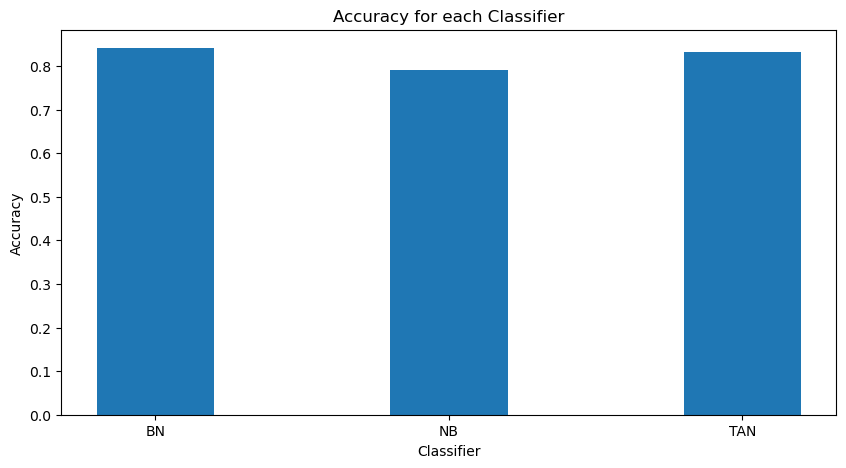

In [432]:
import matplotlib.pyplot as plt 
classifiers = ['BN', 'NB', 'TAN']
accs = [acc_bn, acc_nb, acc_tan]
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classifiers, accs, width = 0.4)
 
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Accuracy for each Classifier")
plt.show()

From the experimental results, it can be observed that the full Bayesian Network performs the best, followed by the Tree-augmented Naïve Bayes classifier (TAN) and the Naïve Bayes classifier, with the accuracy of **0.84**, **0.83** and **0.79** respectively. The full Bayesian Network has the highest performance than the other two classifiers because the model allows the definition of conditional dependencies and correlations between variables in a more flexible way, thus it is able to capture the complex dependencies and relationships in the data more accurately. In contrast, the Naïve Bayes classifier defines the conditional dependencies in a naïve way, where it assumes that all variables are conditionally independent given the class variable. This assumption limits the flexibility and applicability of the algorithm as some features are conditionally dependent in this case (as well as the real-world cases). The TAN classifier performs better than the Naïve Bayes classifier because it learns the graph structure from the mutual information between variables. 

In terms of the run time and coding complexity, the Naïve Bayes classifier outperforms the other two due to the simplicity of algorithm. While the full Bayesian network is capable of flexible modelling between variables, it may have a higher computational time and coding complexity during the inference compared to the former classifier as the number of variables and dependencies increases. The TAN classifier itself has approximately the same runtime as Naïve Bayes but it becomes computationally expensive due to the computation of mutual information. 

The time and space complexity of the full Bayesian Network is exponential, which is $O(P^N * C)$, where $P$ is the maximum number of values in each variable, $N$ is the number of variables and $C$ is the number of classes. For instance, there are 13 variables ($N$), assume the maximum number of values of the corresponding variable is 3 ($P$) and the number of values of the class variable is 3, there would be a total of $3^{13} * 3$ of combinations. On the other hand, the time and space complexity of the Naïve Bayes network is $O(N * C)$ as we need to compute the conditional probability for each variable given the class. For the TAN classifier, we need to compute the conditional probability of each variable, conditioned to its parent and the class variable, therefore the time complexity is polynomial, which is $O(N * P^2 * C)$.